In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, concatenate, GlobalAveragePooling2D
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image

In [22]:
# Load the CSV dataset
dataset = pd.read_csv('D:/Thesis Code/datasets/english.csv')

In [23]:
image_paths = dataset['image'].values
labels = dataset['label'].values

In [24]:
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

In [25]:
num_classes = len(label_encoder.classes_)
labels = to_categorical(labels, num_classes)

In [26]:
# Split the dataset into training and testing sets
train_paths, test_paths, train_labels, test_labels = train_test_split(image_paths, labels, test_size=0.2, random_state=42)


In [27]:
input_shape = (28, 28)
batch_size = 32
epochs = 100

In [29]:
# Create an ImageDataGenerator for data augmentation
augmented_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.2,
    fill_mode='nearest'
)

In [30]:
input_layer = Input(shape=input_shape + (1,))
conv1_3x3 = Conv2D(32, kernel_size=(3, 3), activation='relu')(input_layer)
conv1_5x5 = Conv2D(32, kernel_size=(5, 5), activation='relu')(input_layer)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1_5x5)

conv2_3x3 = Conv2D(64, kernel_size=(3, 3), activation='relu')(pool1)
conv2_5x5 = Conv2D(64, kernel_size=(5, 5), activation='relu')(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2_5x5)

# Apply Global Average Pooling to each convolutional stream
gap_conv2_3x3 = GlobalAveragePooling2D()(conv2_3x3)
gap_conv2_5x5 = GlobalAveragePooling2D()(conv2_5x5)
gap_pool2 = GlobalAveragePooling2D()(pool2)

# Concatenate the global average pooled features
merged = concatenate([gap_conv2_3x3, gap_conv2_5x5, gap_pool2], axis=-1)
dense1 = Dense(128, activation='relu')(merged)
output_layer = Dense(num_classes, activation='softmax')(dense1)

model = Model(inputs=input_layer, outputs=output_layer)

In [31]:
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [32]:
# Load and preprocess images from paths
def preprocess_image(image_path):
    img = Image.open(image_path).convert('L')
    img = img.resize(input_shape)
    img = np.array(img)
    img = img / 255.0
    img = img.reshape(input_shape + (1,))
    return img

In [34]:
# Train the model with data augmentation
augmented_train_images = []
augmented_train_labels = []

for image_path, label in zip(train_paths, train_labels):
    img = preprocess_image(image_path)
    augmented_images = augmented_datagen.flow(np.expand_dims(img, axis=0), batch_size=32)
    for i in range(32):
        augmented_train_images.append(augmented_images.next()[0])
        augmented_train_labels.append(label)

augmented_train_images = np.array(augmented_train_images)
augmented_train_labels = np.array(augmented_train_labels)

test_images = [preprocess_image(image_path) for image_path in test_paths]
test_images = np.array(test_images)

In [35]:
history = model.fit(
    augmented_train_images,
    augmented_train_labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(test_images, test_labels),
    verbose=1
)


Train on 87296 samples, validate on 682 samples
Epoch 1/100
87296/87296 [==============================] - 30s 339us/step - loss: 2.2978 - accuracy: 0.3733 - val_loss: 0.9678 - val_accuracy: 0.7141
Epoch 2/100
87296/87296 [==============================] - 30s 341us/step - loss: 0.9963 - accuracy: 0.6901 - val_loss: 0.8157 - val_accuracy: 0.7713
Epoch 3/100
87296/87296 [==============================] - 30s 339us/step - loss: 0.7065 - accuracy: 0.7695 - val_loss: 0.7181 - val_accuracy: 0.7874
Epoch 4/100
87296/87296 [==============================] - 30s 338us/step - loss: 0.5667 - accuracy: 0.8094 - val_loss: 0.6539 - val_accuracy: 0.8050
Epoch 5/100
87296/87296 [==============================] - 29s 337us/step - loss: 0.4767 - accuracy: 0.8343 - val_loss: 0.7546 - val_accuracy: 0.8021
Epoch 6/100
87296/87296 [==============================] - 29s 338us/step - loss: 0.4184 - accuracy: 0.8526 - val_loss: 0.7343 - val_accuracy: 0.8079
Epoch 7/100
87296/87296 [==========================

In [36]:
# Evaluate the model
accuracy = model.evaluate(test_images, test_labels, verbose=0)[1]
print("Test accuracy:", accuracy)

Test accuracy: 0.8108504414558411


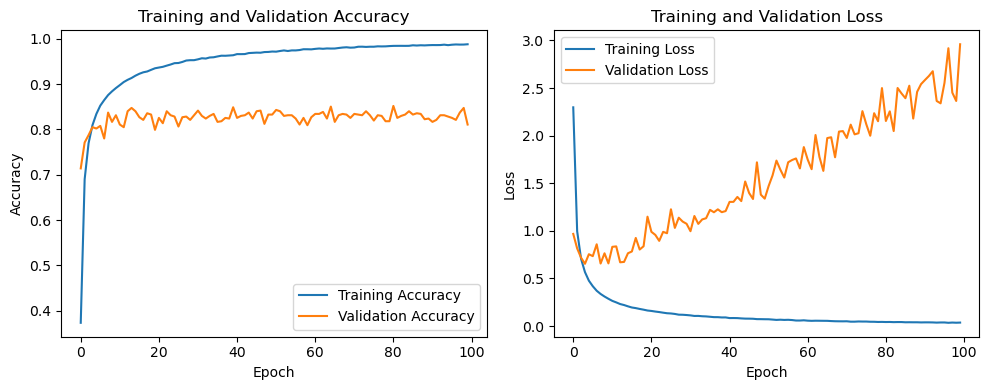

Final training accuracy: 0.9880
Final validation accuracy: 0.8109
The model might be overfitting the training data.


In [41]:
# Plot training history
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Assess model performance
final_train_accuracy = history.history['accuracy'][-1]
final_val_accuracy = history.history['val_accuracy'][-1]
print(f"Final training accuracy: {final_train_accuracy:.4f}")
print(f"Final validation accuracy: {final_val_accuracy:.4f}")

# Check for overfitting or underfitting
if final_train_accuracy > final_val_accuracy:
    print("The model might be overfitting the training data.")
elif final_train_accuracy < final_val_accuracy:
    print("The model might be underfitting the training data.")
else:
    print("The model's training and validation accuracies are balanced.")

Predicted label: 0


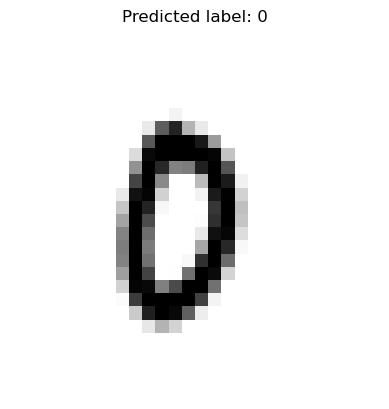

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

In [40]:

# Predict using the trained model
sample_image_path = 'Img/img001-002.png'  # Replace with the path to your sample image
sample_image = preprocess_image(sample_image_path)
sample_image = np.expand_dims(sample_image, axis=0)
prediction = model.predict(sample_image)
predicted_label = np.argmax(prediction)

# Decode the predicted label using the label encoder
decoded_predicted_label = label_encoder.inverse_transform([predicted_label])[0]
print("Predicted label:", decoded_predicted_label)

# Display the sample image along with the prediction
plt.imshow(sample_image[0, :, :, 0], cmap='gray')
plt.title(f"Predicted label: {decoded_predicted_label}")
plt.axis('off')
plt.show()

# Plot training history
plt.figure(figsize=(10, 4))